In [1]:
import pyubx2
import os
import datetime
from tqdm import tqdm

class GPSTimeConv(object):

    @staticmethod
    def week_ts(weekNumber):
        # 2139 = 2021-01-03 00:00:00
        return (datetime.datetime(2021, 1, 3) + datetime.timedelta(7*(weekNumber-2139))).timestamp()

    # this is loosing precision to about 10 ns !!
    @staticmethod
    def timestamp(wn, towMs, towSubMs):
        return GPSTimeConv.week_ts(wn) + towMs/1e3 + towSubMs/1e9

    @staticmethod
    def tow(towMs, towSubMs, offset=0):
        return towMs/1e3 + towSubMs/1e9 - offset

class TIMTM2(object):

    def __init__(self, ubxmessage):
        self.msg = ubxmessage
    
    # this is loosing precision to about 10 ns !!
    @property
    def raiseTm(self):
        try:
            return GPSTimeConv.timestamp(self.msg.wnR, self.msg.towMsR, self.msg.towSubMsR)
        except:
            return None

    @property
    def raiseWn(self):
        try:
            return self.wnR
        except:
            return None

    @property
    def raiseTow(self):
        try:
            return GPSTimeConv.tow(self.msg.towMsR, self.msg.towSubMsR, 0)
        except:
            return None

    @property
    def accEst(self):
        try:
            return self.msg.accEst
        except:
            return None

class UbxFilter(object):
    def __init__(self, filename):
        self.filename = filename
    
    def name(self, msgid):
        return pyubx2.UBX_MSGIDS[self.msgid] if self.msgid else None

    def filterMessages(self, msgids):
        with open(self.filename, 'rb') as fin:
            ureader = pyubx2.UBXReader(fin, False)
            msgs = iter(ureader)
            while True:
                try:
                    msg = next(msgs)
                    if (msg[1].identity in msgids):
                        yield msg[1]
                except StopIteration:
                    break
                except:
                    pass 

Read input data from TIM-TM2 messages

In [2]:
#        UBX-TIM-SMEAS, 
#        UBX-TIM-TM2,   # timestamp of extrnal input
#        UBX-TIM-TOS,   # offset and uncertainty of generated timepulse (corrections when measured externally agains something else)
infilename = '/Users/dorsic/Development/github/u-blox/measurements/pico_xosc/lea-m8t_pico_xocs.ubx'
ufilter = UbxFilter(infilename)
msgs = iter(ufilter.filterMessages(['TIM-TM2']))
tm2R = [TIMTM2(x) for x in ufilter.filterMessages(['TIM-TM2'])]

Convert the TIM-TM2 data to period data.
Missing values are interpolated. Time mark (time of week) is written in the last column. The difference from previous time mark is in the first column.

In [1]:
fperiod = '/Users/dorsic/Development/github/u-blox/measurements/pico_xosc/lea-m8t_pico_xocs.period'

In [ ]:
with open(fperiod, 'w') as fout:
    lasttm = None
    for tm2 in tm2R:
        timemark = tm2.raiseTow
        if timemark:
            if lasttm:
                dif = timemark-lasttm
                if np.abs(1-dif) < 0.01:
                    fout.write(str(dif) + "\t b''\t" + str(timemark) + "\t" + str(tm2.accEst) + "\n")
                else:
                    n = np.int(np.round(dif))
                    if n < 100:
                        for i in range(n):
                            val = dif/np.int(np.round(dif))
                            fout.write(str(val) + "\t b'interpolated'\t" + str(lasttm+val*(i+1)) + "\t999\n")
            else:
                fout.write("1\t b'' \t" + str(tm2) + "\n")
            lasttm = timemark

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import allantools

In [25]:
df = pd.read_csv(fperiod, delimiter='\t', names=["Y", "BIN", "X", "EACC"])
print("Zahodenych {0} merani mimo ocakavany rozsah.".format(len(df[df['Y']<=0.8])))
df = df[df['Y']>0.8][1:]

Zahodenych 0 merani mimo ocakavany rozsah.


Show the data sample differences

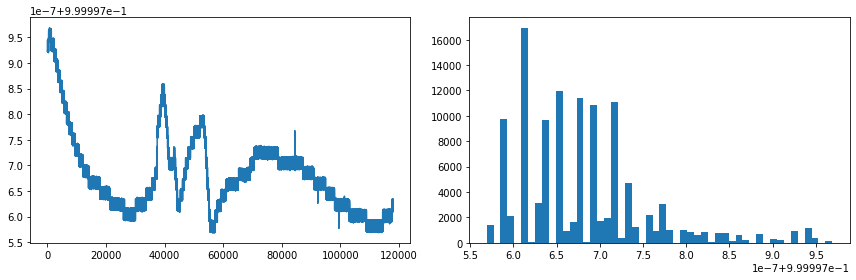

In [26]:
# histogram
mn = np.mean(df['Y'])
span = 5*np.std(df['Y'])
dfs = df[((mn-span)<df['Y']) & (df['Y']<(mn+span))]

#plt.figsize(10, 5)
fig, axes = plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
df['Y'].plot()

plt.subplot(1,2,2)
plt.hist(dfs['Y'], bins=50)

plt.tight_layout()
plt.show()

In [82]:
mx = np.mean(df['Y'])
sx = np.std(df['Y'])
print("Offset is {0:.2f} +- {1:.2f} ns (2sigma)".format( (mx-1.0)*1e9, 2*sx*1e9))
print("Freq offset is {0:.1f} +- {1:.3f} ppb (2sigma)".format((1-mx)*1e9, 2*sx*1e9))

Offset is -2319.15 +- 151.58 ns (2sigma)
Freq offset is 2319.1 +- 151.579 ppb (2sigma)


Do mean of timemark difference and stdev converge?

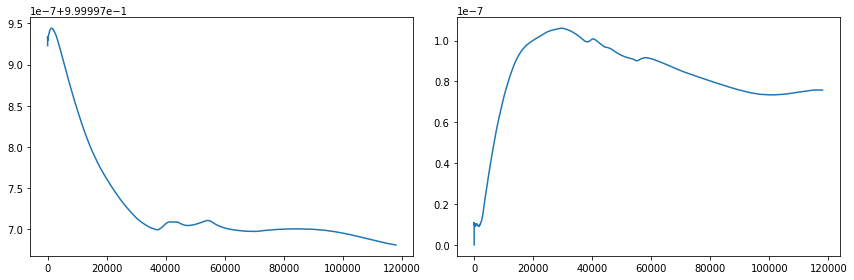

In [31]:
df['cAvg'] = np.NaN
df['cStd'] = np.NaN
for i in range(1, len(df)):
    df.loc[i, ['cAvg']] = np.mean(df[0:i]['Y'])
    df.loc[i, ['cStd']] = np.std(df[0:i]['Y'])

fig, axes = plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
df['cAvg'].plot()

plt.subplot(1,2,2)
df['cStd'].plot()

plt.tight_layout()
plt.show()

Try linear regression of timemarks

[9.99997676e-01 8.08884293e+04]
ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:>

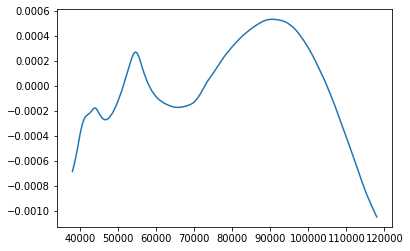

In [62]:
sdf = df[38000:]
lreg = np.polyfit(sdf.index, sdf['X'], deg=1)
print(lreg)

sdf["LR_residuals"] = sdf['X'] - (sdf.index*lreg[0] + lreg[1])
sdf['LR_residuals'].plot()


In [83]:
print("Nominal frequency offset is {0:.1f} ppb.".format((1-lreg[0])*1e9))

Nominal frequency offset is 2323.9 ppb.


Straight forward computations of difference between first and last timemark.

In [108]:
(sdf.iloc[-1]['X']-sdf.iloc[1]['X'])-(sdf.index[-1]-1)


-38001.186330390046

In [105]:
(df.iloc[-1]['X']-df.iloc[1]['X'])

119886.72208859796

In [107]:
df.iloc[1]['X']

79027.43186882099

In [7]:
tm2R[1].msg.towMsF

79026931